In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline, BSpline

import re
pattern = re.compile(r'\d+') 

In [2]:
#%%file function_definitions.py

def h5_in_xarray(field):
    data = hf.get('%s' % field)
    x1 = hf.get('x-coord')
    x2 = hf.get('y-coord')
    x3 = hf.get('z-coord')
    xr_data = xr.DataArray(
        np.array(data),
        dims = ("x", "y", "z"),
        coords = { "x" : np.array(x1),
                  "y" : np.array(x2),
                  "z" : np.array(x3)
        }   
    )
    
    return xr_data

def create_xarray(u):
    
    # This function creates an xarray that has same data size and coordinates aligned with the input xarray u
    new_array = xr.DataArray(
        np.empty(u.shape),
        dims = ("x", "y", "z"),
        coords = { "x" : u['x'],
              "y" : u['y'],
              "z" : u['z']
        }
    )
    
    return new_array

def intp_w_to_uvp(w, u):
    
    # This function interpolates w to uvp nodes
    w_intp = create_xarray(u)
    w_intp[:, :, :-1] = w.interp(z = u['z'][:-1])
    w_intp[:, :, u['z'].size - 1] = 0
    
    return w_intp

In [3]:
# Let's load the entire data
path = "/Users/erikvanwinkle/Documents/DeSci Labs_files/Marco Node/Node Data/Processed Data"
f = {} # Loads all the variables
h5_files = os.listdir('%s/pressure_corrected_domain_averages' % path)
h5_files = [match for match in h5_files if "rvv" in match and "_16x" not in match and "_12x" not in match]
filepath = '%s/pressure_corrected_domain_averages' % path

for sim in h5_files:
    hf = h5py.File('%s/%s' % (filepath, sim), 'r')
    f['rvv%s' % (sim[8:-3])] = h5_in_xarray('v_rii')

In [4]:
h5_files = os.listdir('%s/pressure_corrected_domain_averages' % path)
h5_files = [match for match in h5_files if "restart0" in match and "_16x" in match and 'rvv' in match and 'run2' not in match]
for sim in h5_files:
    sim = sim[8:-12]
    i = 0
    sim_name = "rvv_chan%s_restart%d.h5" % (sim, i)
    hf = h5py.File('%s/%s' % (filepath, sim_name), 'r')
    f['rvv%s' % (sim)] = h5_in_xarray('v_rii')
    
    for i in range(1, 4):
        sim_name = "rvv_chan%s_restart%d.h5" % (sim, i)
        hf = h5py.File('%s/%s' % (filepath, sim_name), 'r')
        f['rvv%s' % (sim)] += h5_in_xarray('v_rii')

    if "l2_16x48" in sim or "l2_16x72" in sim:
        for i in range(4):
            sim_name = "rvv_chan%s_restart%d_run2.h5" % (sim, i)
            hf = h5py.File('%s/%s' % (filepath, sim_name), 'r')
            f['rvv%s' % (sim)] += h5_in_xarray('v_rii')
        f['rvv%s' % (sim)] /= 8
    else:
        f['rvv%s' % (sim)] /= 4

In [5]:
h5_files = os.listdir('%s/longerx_averages' % path)
h5_files = [match for match in h5_files if "restart0" in match and 'rvv' in match and 'run2' not in match]
filepath = '%s/longerx_averages' % path
for sim_ in h5_files:
    pattern = re.search('rvv_chan(_l\d+_\d+x\d+x\d+)_.*', sim_)
    sim = pattern.group(1)
    i = 0
    sim_name = "rvv_chan%s_restart%d.h5" % (sim, i)
    hf = h5py.File('%s/%s' % (filepath, sim_name), 'r')
    f['rvv%s' % (sim)] = h5_in_xarray('v_rii')
    
    for i in range(1, 4):
        sim_name = "rvv_chan%s_restart%d.h5" % (sim, i)
        hf = h5py.File('%s/%s' % (filepath, sim_name), 'r')
        f['rvv%s' % (sim)] += h5_in_xarray('v_rii')
        
    f['rvv%s' % (sim)] /= 4

In [6]:
# Loading variance data
field_list = ['v', 'vv']
h5_files = os.listdir('%s/pressure_corrected_domain_averages' % path)
h5_files = [match for match in h5_files if "chan" in match and "_16x" not in match and "_12x" not in match and "ruu" not in match and "rvv" not in match]
filepath = '%s/pressure_corrected_domain_averages' % path

for sim in h5_files:
    hf = h5py.File('%s/%s' % (filepath, sim), 'r')
    for field in field_list:
        f['%s%s' % (field, sim[4:-3])] = h5_in_xarray(field)
        
h5_files = os.listdir('%s/pressure_corrected_domain_averages' % path)
h5_files = [match for match in h5_files if "restart0" in match and "_12x" not in match and "ruu" not in match and "rvv" not in match and "run2" not in match]
for sim in h5_files:
    sim = sim[4:-12]
    i = 0
    sim_name = "chan%s_restart%d.h5" % (sim, i)
    hf = h5py.File('%s/%s' % (filepath, sim_name), 'r')
    for field in field_list:
        f['%s%s' % (field, sim)] = h5_in_xarray(field)
    
    for i in range(1, 4):
        sim_name = "chan%s_restart%d.h5" % (sim, i)
        hf = h5py.File('%s/%s' % (filepath, sim_name), 'r')
        for field in field_list:
            f['%s%s' % (field, sim)] += h5_in_xarray(field)

    if "l2_16x48" in sim or "l2_16x72" in sim:
        for i in range(4):
            sim_name = "chan%s_restart%d_run2.h5" % (sim, i)
            hf = h5py.File('%s/%s' % (filepath, sim_name), 'r')
            for field in field_list:
                f['%s%s' % (field, sim)] += h5_in_xarray(field)
        
        for field in field_list:
            f['%s%s' % (field, sim)] /= 8
    else:
        for field in field_list:
            f['%s%s' % (field, sim)] /= 4


h5_files = os.listdir('%s/longerx_averages' % path)
filepath = '%s/longerx_averages' % path
h5_files = [match for match in h5_files if "restart0" in match and "ruu" not in match and "rvv" not in match and "run2" not in match]
for sim in h5_files:
    sim = sim[4:-12]
    i = 0
    sim_name = "chan%s_restart%d.h5" % (sim, i)
    hf = h5py.File('%s/%s' % (filepath, sim_name), 'r')
    for field in field_list:
        f['%s%s' % (field, sim)] = h5_in_xarray(field)
    
    for i in range(1, 4):
        sim_name = "chan%s_restart%d.h5" % (sim, i)
        hf = h5py.File('%s/%s' % (filepath, sim_name), 'r')
        for field in field_list:
            f['%s%s' % (field, sim)] += h5_in_xarray(field)

    for field in field_list:
        f['%s%s' % (field, sim)] /= 4

In [7]:
# Now, I need to load the uu variance to normalize autocorrelation
h5_files_list = os.listdir('%s/pressure_corrected_domain_averages' % path)
h5_files = [match[4:-3] for match in h5_files_list if "_16x" not in match and "_12x" not in match and "chan" in match and "ruu" not in match and "rvv" not in match]
h5_files_16 = [match[4:-12] for match in h5_files_list if "restart0" in match and "_16x" in match and "ruu" not in match and "rvv" not in match and "run2" not in match]
h5_files_longerx = os.listdir('%s/longerx_averages' % path)
h5_files_longerx = [match[4:-12] for match in h5_files_longerx if "restart0" in match and "ruu" not in match and "rvv" not in match and "run2" not in match]
h5_files += h5_files_longerx + h5_files_16

var_list = ['vv']
temp = {}

for sim in h5_files:
    for v in var_list:
        temp["%s%s" % (v, sim)] = f["%s%s" % (v, sim)].mean(dim = ['x', 'y']) - (f["%s%s" % (v[0], sim)] * f["%s%s" % (v[1], sim)]).mean(dim = ['x', 'y'])
        
disp = {}

for sim in h5_files:
    for v in var_list:
        disp["%s%s" % (v, sim)] = (f["%s%s" % (v[0], sim)]*f["%s%s" % (v[1], sim)]).mean(dim = ['x', 'y']) - f["%s%s" % (v[0], sim)].mean(dim = ['x', 'y']) * f["%s%s" % (v[1], sim)].mean(dim = ['x', 'y'])
        
stress = {}

for sim in h5_files:
    for v in var_list:
        stress["%s%s" % (v, sim)] = temp["%s%s" % (v, sim)] + disp["%s%s" % (v, sim)]     

In [8]:
key_list = list(f.keys())
key_list = [match[4:] for match in key_list if "rvv" in match]

In [9]:
norm_rii={}

for key in key_list:
    norm_rii["%s" % key] = f["rvv_%s" % key] / stress["vv_%s" % key]

In [10]:
def shift_quadrants(xarray):
    shifted_array = np.empty(xarray.shape)
    lx = int(len(xarray['x']) / 2)
    ly = int(len(xarray['y']) / 2)
    
    shifted_array[:lx, :ly, :] = xarray[lx:, ly:, :].values
    shifted_array[lx:, :ly, :] = xarray[:lx, ly:, :].values
    shifted_array[:lx, ly:, :] = xarray[lx:, :ly, :].values
    shifted_array[lx:, ly:, :] = xarray[:lx, :ly, :].values
    
    shifted_x = xarray['x'] - (xarray['x'][-1]) / 2
    shifted_y = xarray['y'] - (xarray['y'][-1]) / 2
    return shifted_array, shifted_x, shifted_y

In [11]:
# Now I need to find out the integral length scale based on quadrant data
def output_quadrant(key):
    
    norm_rii['%s' % key] = norm_rii['%s' % key] / norm_rii['%s' % key].max()
    lx = int(len(norm_rii['%s' % key]['x']) / 2)
    ly = int(len(norm_rii['%s' % key]['y']) / 2)
    quadrant = norm_rii['%s' % key][:lx, :ly, :]
    
    return quadrant

def output_yloc(xarray, z, cutoff_val):
    # This function outputs xloc of cutoff value for a given z
    for i in range(xarray['y'].size):
        if xarray[0, i, z] < cutoff_val:
            break;

    # also calculating residual length (which is smaller than the grid size based on interpolation)
    left_val = xarray[0, i-1, z].values
    right_val = xarray[0, i, z].values
    dr = (xarray['y'][1] - xarray['y'][0]).values
    delta_req   = left_val - cutoff_val
    delta_grid = left_val - right_val
    residual = dr * delta_req / delta_grid 
    return i , residual

def calc_L22(xarray, cutoff):
    # Calculating integral length scale for the quadrant
    
    znodes = xarray['z'].size 
    l = np.empty(znodes)
    dr = xarray['y'][1] - xarray['y'][0]
    
    for i in range(znodes):
        y_loc, residual = output_yloc(xarray, i, cutoff)
        l[i] = np.sum(xarray[0, :y_loc - 1, i]) * dr.values  + xarray[0, y_loc - 1, i] * residual
    
    return l

### Figure 6

Text(0.055, 0.5, '$x_3/L_3$')

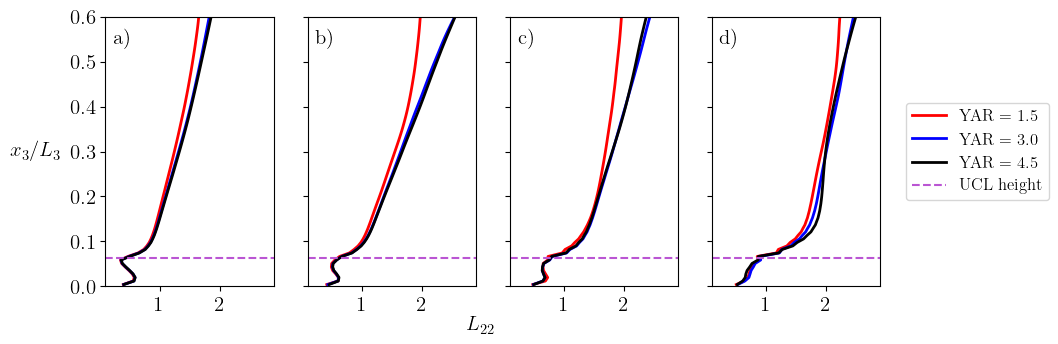

In [12]:
from matplotlib import rc
import matplotlib
rc('font',weight='bold',size=15,family='serif',serif='Computer Modern Roman')
rc('text', usetex=True)
pattern = re.compile(r'\d+')

fig1, axs = plt.subplots(nrows=1, ncols=4, figsize=(10,3.5), sharey=True)

pack_list = ["l2", "l4", "l6", "l12"]
for index, pack_den in enumerate(pack_list):   
    key_list = ["%s_16x24x96" % pack_den, "%s_16x48x96" % pack_den, "%s_16x72x96" % pack_den]
    namelist = ['a)', 'b)', 'c)', 'd)']
    clist = ['r', 'b', 'k']
    for index1, key in enumerate(key_list):
        match = pattern.findall(key)
        delta = int(match[1])
        ly = int(match[2])
        quadrant = output_quadrant(key)
        l22 = calc_L22(quadrant, 0.4)
        if index == 3:
            axs[index].plot(l22[:80], quadrant['z'][:80] / delta, clist[index1], linewidth=2, label='YAR = %.1f' % float(ly/delta))
        else:
            axs[index].plot(l22[:80], quadrant['z'][:80] / delta, clist[index1], linewidth=2)
    plt.text(0.1, 0.9, namelist[index], horizontalalignment='center', transform=axs[index].transAxes,fontsize=15)
    axs[index].set_ylim(0, 0.6)
    axs[index].set_xlim(0.1, 2.9)
    axs[index].set_xticks([1, 2])
    axs[index].plot(np.linspace(0.1, 2.9, 20), np.ones(20) * 1/delta, color='mediumorchid', linestyle='dashed', linewidth=1.5, label='UCL height')
axs[3].legend(loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=12)
fig1.text(0.5, 0, r'$L_{22}$', ha='center', va='center', fontsize=15)
fig1.text(0.055, 0.5, r'$x_3/L_3$', ha='center', va='center', rotation='horizontal', fontsize=15)
